In [ ]:
# Umum
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

# HuggingFace Transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

# Keras - Callbacks & Utilities
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Keras - Model Building (Functional & Sequential APIs)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional
)

# Keras - Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!pip install nltk
import nltk

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### **LANGKAH 1 : Persiapan dataset review whatsapp**

In [ ]:
# Load dataset
df = pd.read_csv("../data/instagram_reviews.csv")

# Periksa 5 baris pertama untuk memahami struktur dataset
df.head()

,userName,score,content,at
0,Natti Felix,1,"the app itself is a good idea, I love features...",2025-03-14 15:56:20
1,Taylor Coiner,3,i love this app but there is a few bugs that m...,2025-03-26 03:17:59
2,Robert Schneider,4,I still like the content on the app is still g...,2025-01-29 03:26:45
3,Rae Tritt,1,this whole update is complete and utter garbag...,2025-01-17 23:06:32
4,Brandon Siegel,3,For the love of God make up your minds. At fir...,2025-03-04 21:35:48


In [5]:
# Hapus baris dengan missing values
df.dropna(inplace=True)

# Verifikasi bahwa tidak ada lagi missing values
print(df.isnull().sum())


userName    0
score       0
content     0
at          0
dtype: int64


In [6]:
df.describe()

,score
count,39999.000000
mean,2.114328
std,1.423975
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,5.000000


In [7]:
df.shape

(39999, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39999 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  39999 non-null  object
 1   score     39999 non-null  int64 
 2   content   39999 non-null  object
 3   at        39999 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


## 📊 Penjelasan Dataset Ulasan Instagram

Dataset ini diperoleh menggunakan **Google Play Scraper** dari **Google Play Store** dan berisi **39.999 ulasan** dari pengguna Instagram.  
Analisis ini bertujuan untuk mengevaluasi **sentimen berdasarkan skor rating serta isi ulasan yang diberikan oleh pengguna**.  

### 📌 Struktur Data  
| Kolom    | Non-Null Count | Tipe Data | Deskripsi |
|----------|---------------|-----------|------------|
| `userName` | 39,999       | object    | Nama pengguna yang memberikan ulasan |
| `score`    | 39,999       | int64     | Skor rating yang diberikan (1-5) |
| `content`  | 39,999       | object    | Isi ulasan yang diberikan pengguna |
| `at`       | 39,999       | object    | Tanggal ulasan diposting |

### 🔍 Catatan Penting  
- **Kolom `content`** akan menjadi fokus utama dalam analisis sentimen.  
- **Kolom `score`** dapat digunakan sebagai label sentimen, dengan skala berikut:  
  - **1–2** = Sentimen Negatif  
  - **3** = Sentimen Netral  
  - **4–5** = Sentimen Positif  
- **Pra-pemrosesan teks diperlukan**, termasuk:  
  - Menghapus **emoji, tag HTML, dan karakter khusus**.  
  - Menangani **teks dalam berbagai bahasa** agar lebih konsisten dalam analisis.  

---

✍️ *Catatan:*  
- Dataset ini hanya mencakup ulasan dalam bahasa Inggris (`lang='en'`) dan berasal dari pengguna di AS (`country='us'`).  
- Jika diperlukan, dataset dapat diperluas dengan mengambil lebih banyak ulasan atau menambahkan bahasa lain untuk analisis lebih menyeluruh.  


# Preprocessing data


In [9]:
df['at'] = pd.to_datetime(df['at']).dt.date

In [10]:
df.head()

,userName,score,content,at
0,Natti Felix,1,"the app itself is a good idea, I love features...",2025-03-14
1,Taylor Coiner,3,i love this app but there is a few bugs that m...,2025-03-26
2,Robert Schneider,4,I still like the content on the app is still g...,2025-01-29
3,Rae Tritt,1,this whole update is complete and utter garbag...,2025-01-17
4,Brandon Siegel,3,For the love of God make up your minds. At fir...,2025-03-04


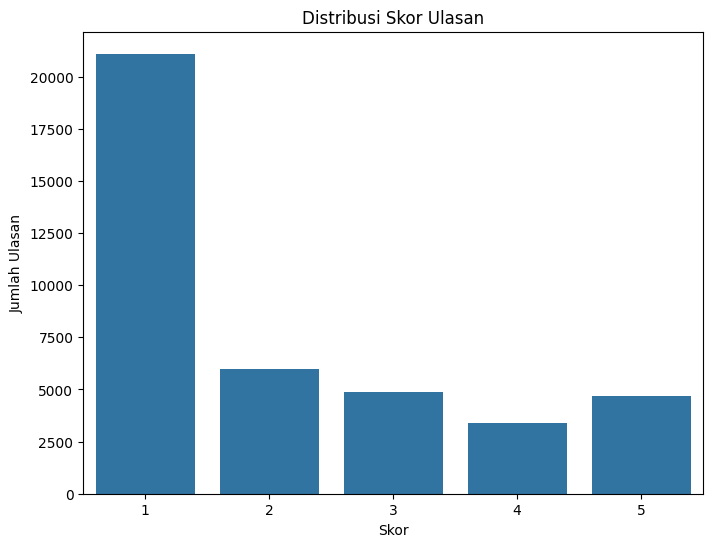

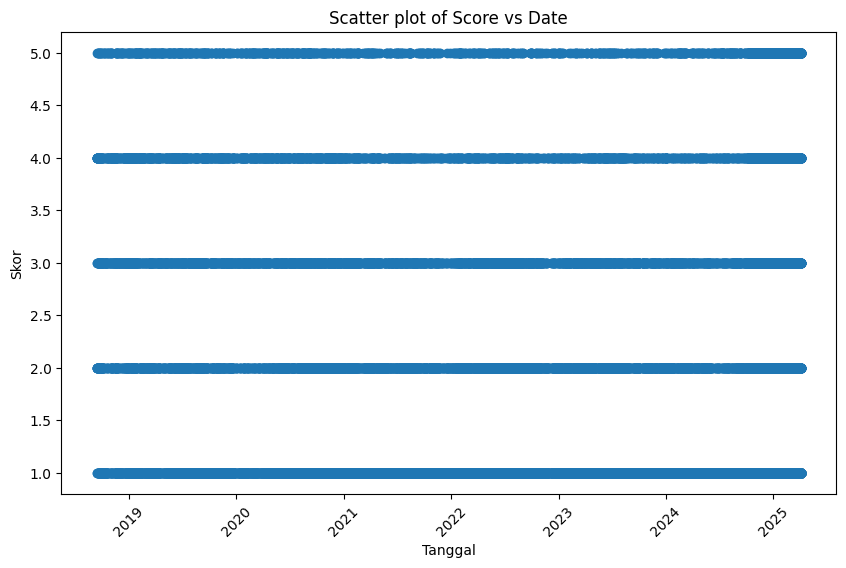

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi skor
plt.figure(figsize=(8, 6))
sns.countplot(x='score', data=df)
plt.title('Distribusi Skor Ulasan')
plt.xlabel('Skor')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Untuk visualisasi lebih lanjut, bisa juga dibuat scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df['at'], df['score'])
plt.xlabel("Tanggal")
plt.ylabel("Skor")
plt.title("Scatter plot of Score vs Date")
plt.xticks(rotation = 45)
plt.show()


### 📊 Distribusi Skor Ulasan Instagram

Grafik batang di atas menunjukkan distribusi skor ulasan yang diberikan oleh pengguna terhadap aplikasi **Instagram**. Skor berkisar dari 1 hingga 5, di mana:

- **Skor 1** mendominasi jumlah ulasan, menandakan banyak pengguna yang memberikan penilaian sangat buruk terhadap aplikasi ini.
- Skor 2, 3, 4, dan 5 memiliki jumlah ulasan yang jauh lebih sedikit dibanding skor 1.
- **Skor 4** merupakan skor dengan jumlah ulasan paling rendah.

#### 🔍 Insight:

- Tingginya skor 1 bisa menandakan adanya ketidakpuasan besar pada fitur atau performa aplikasi dalam periode tertentu.
- Jumlah ulasan dengan skor tinggi (4–5) masih cukup signifikan, menunjukkan adanya pengalaman positif dari sebagian pengguna.
- Analisis lebih lanjut terhadap isi ulasan dapat memberikan pemahaman yang lebih mendalam mengenai penyebab dominannya skor rendah.


In [12]:
df_no_duplicates = df.drop_duplicates()

if df.shape != df_no_duplicates.shape:
    print("Duplicates were removed.")
else:
    print("No duplicates found.")


Duplicates were removed.


In [13]:
from nltk.corpus import words
import re

english_words = set(words.words())

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions (@username)
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters (including emojis)
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def is_english(text):
    if not isinstance(text, str) or not text.strip():
        return False

    words_in_text = text.split()
    if not words_in_text:
        return False

    english_count = sum(1 for word in words_in_text if word in english_words)
    return english_count / len(words_in_text) >= 0.6

# Apply cleaning function
df['content_cleaned'] = df['content'].apply(clean_text)

# Filter for only English rows
df = df[df['content_cleaned'].apply(is_english)]

# Drop empty rows (if any)
df = df[df['content_cleaned'].str.strip() != '']

In [14]:
# Show sample after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
15604,It's really annoying! Everytime I open my Inst...,its really annoying everytime i open my instag...
3551,I'm unable to access the scroll feature in cha...,im unable to access the scroll feature in chat...
19879,Rather annoyed by the fact the InstagramTV vid...,rather annoyed by the fact the instagramtv vid...
36428,I've been using this app for a couple of years...,ive been using this app for a couple of years ...
30424,One of the very few apps that do the stories r...,one of the very few apps that do the stories r...
38684,The display of my profile is distorted it's be...,the display of my profile is distorted its bee...
18868,Nice app for social working and social media ....,nice app for social working and social media i...
371,"When making stories, on the albums when we're ...",when making stories on the albums when were go...
5024,"This is beyond horrible, I tried making an acc...",this is beyond horrible i tried making an acco...
28827,Yes it's a good app for expressing and enterta...,yes its a good app for expressing and entertai...


In [15]:
import re

# Define a dictionary of slang words and their formal replacements
slang_dict = {
    "idk": "I don't know",
    "nvm": "never mind",
    "sup": "what's up",
    "gonna": "going to",
    "wanna": "want to",
    "aint": "is not",
    "jk": "just kidding",
    "ty": "thank you",
    "b4": "before",
    "y'all": "you all",
    "omg": "oh my god",
    "smh": "shaking my head",
    "btw": "by the way",
    "brb": "be right back",
    "im": "I am",
    "omw": "on my way",
    "ur": "your",
    "gr8": "great",
    "fyi": "for your information",
    "r": "are",
    "lmk": "let me know",
    "gimme": "give me",
    "bc": "because",
    "gotta": "got to",
    "dm": "direct message",
    "afaik": "as far as I know",
    "gam": "game",
    "u": "you",
    "dis": "this",
    "thx": "thanks",
    "lemme": "let me",
    "tbh": "to be honest",
    "plz": "please",
    "iam": "I am",
    "np": "no problem",
    "lol": "laughing out loud",
    "tf" : "the fuck"
}

# Compile regex pattern for fast lookup
slang_pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b', re.IGNORECASE)

def replace_slang(text):
    """Replace slang words in the given text with their formal equivalents."""
    if isinstance(text, str):
        return slang_pattern.sub(lambda match: slang_dict[match.group(0).lower()], text)
    return text

# Apply slang replacement to 'content_cleaned' column
df['content_cleaned'] = df['content_cleaned'].apply(replace_slang)


In [16]:
# Show some samples after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
24608,The app is amazing I can communicate with frie...,the app is amazing i can communicate with frie...
157,"It was very good, but instagram decided to cha...",it was very good but instagram decided to chan...
24145,please add an option in edit to delete music o...,please add an option in edit to delete music o...
28710,OMG... I'm so disappointed Wprking as SMM and ...,oh my god I am so disappointed wprking as smm ...
16509,It's quite enjoyable! Not much change from the...,its quite enjoyable not much change from the o...
1040,Instagram is hands down one of the best social...,instagram is hands down one of the best social...
37824,My reels option has somehow vanished and i hav...,my reels option has somehow vanished and i hav...
39228,cannot delete account. have gone through the r...,cannot delete account have gone through the re...
3597,5 days ago my Instagram I'd email was changed ...,days ago my instagram id email was changed and...
12242,"It is an fabulous app, but include an setting ...",it is an fabulous app but include an setting o...


In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already available
nltk.download('stopwords')
nltk.download('punkt')

# Load NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Expand stopwords with domain-specific terms (WhatsApp-related)
custom_stopwords = {
    "whatsapp", "chat", "message", "app", "use", "using", "feature", "text",
    "phone", "send", "receive", "call", "contact", "status", "media",
    "work", "update", "version", "problem", "issue", "fix", "bug",
    "like", "love", "hate", "good", "bad", "need", "want",
    "cant", "dont", "doesnt", "isnt", "arent", "wasnt"
}

# Merge both stopword sets
all_stopwords = nltk_stopwords.union(custom_stopwords)

def preprocess_text(text):
    """Preprocess text: lowercasing, removing special characters, tokenization, stopword removal."""
    if not isinstance(text, str) or text.strip() == "":
        return None

    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    processed_tokens = [word for word in tokens if word not in all_stopwords]

    return " ".join(processed_tokens) if processed_tokens else None

# Apply preprocessing safely
if 'content_cleaned' in df.columns:
    df['content_cleaned'] = df['content_cleaned'].astype(str).apply(preprocess_text)
    df.dropna(subset=['content_cleaned'], inplace=True)
else:
    print("Column 'content_cleaned' not found in DataFrame")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Show some samples after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
30698,I don't like the new version at all. There wer...,new already certain section exploring accounts...
37294,It's a great app with an intuitive interface b...,great intuitive interface noticed regions stil...
5053,This app is just awesome you won't regret it i...,awesome wont regret install enjoying muchbut o...
33897,"Dear Instagram, please make Instagram music av...",dear instagram please make instagram music ava...
38034,My account banned without any reason and for a...,account banned without reason appeal photo id ...
35646,I keep getting an error message when trying to...,keep getting error trying load feed past five ...
436,"Horrible updates, hard to use. You can't pause...",horrible updates hard pause videos rewind even...
5255,frequently doesn't send my messages. my wifi /...,frequently messages wifi data perfectly fine m...
25015,I have 2 accounts and one of them everything i...,accounts one everything fine home feed updatin...
34706,I guess there was an update recently? My app i...,guess recently glitchy right hard stops workin...


In [19]:
# Initialize VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Import the SentimentIntensityAnalyzer class

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if isinstance(text, str):
        score = sia.polarity_scores(text)['compound']
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"
    return "Neutral"

# Apply sentiment analysis to the 'content_lemmatized' column
df['sentiment'] = df['content_cleaned'].apply(get_sentiment)

In [20]:
# Show sample results
df[['content_cleaned', 'sentiment']].sample(10)

,content_cleaned,sentiment
33046,timeline order time feed refreshing fast used ...,Positive
23439,really enjoy introduced friend nagging get ten...,Positive
5951,problems samsung editing multiple photos blank...,Negative
8160,share best images reels get preference grow au...,Positive
3379,every glitches sometime able open links sent c...,Positive
1000,used follow certain creators communities algor...,Positive
32659,used fine updates constantly freezes scroll po...,Positive
37070,terrible experience irresponsible customer ser...,Negative
17034,unfortunately leaves much desired ux hard find...,Positive
14187,beautiful nice socal midiameta team sportedble...,Positive


# Tahap explor data


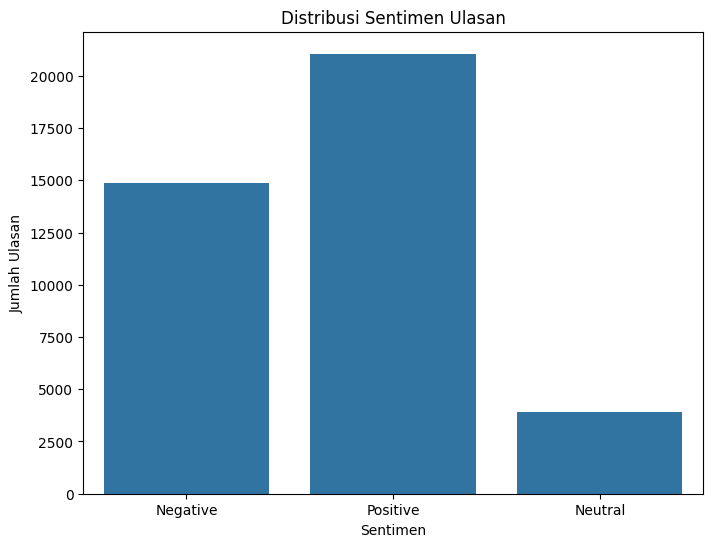

In [21]:
# prompt: visualisasi analisis data pada sentimen

import matplotlib.pyplot as plt
# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Sentimen Ulasan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()




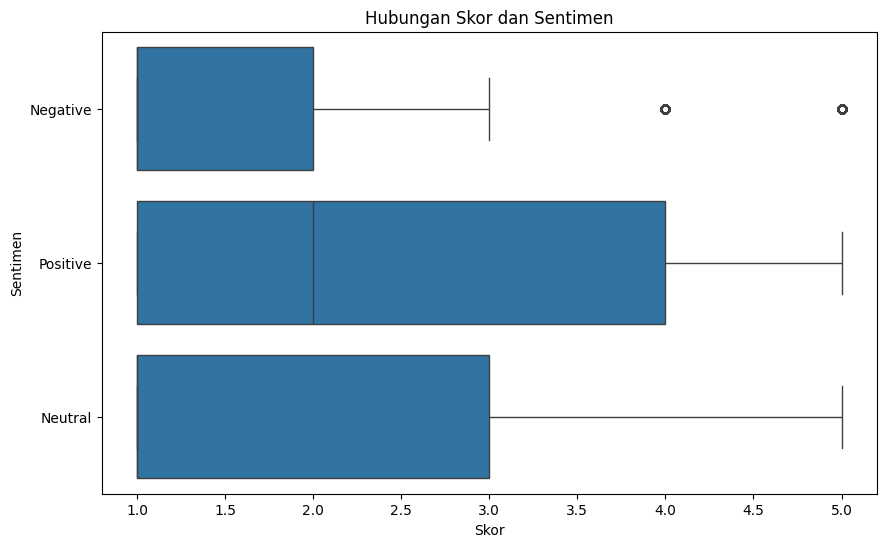

In [22]:
# Visualisasi hubungan antara skor dan sentimen
plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='sentiment', data=df)
plt.title('Hubungan Skor dan Sentimen')
plt.xlabel('Skor')
plt.ylabel('Sentimen')
plt.show()


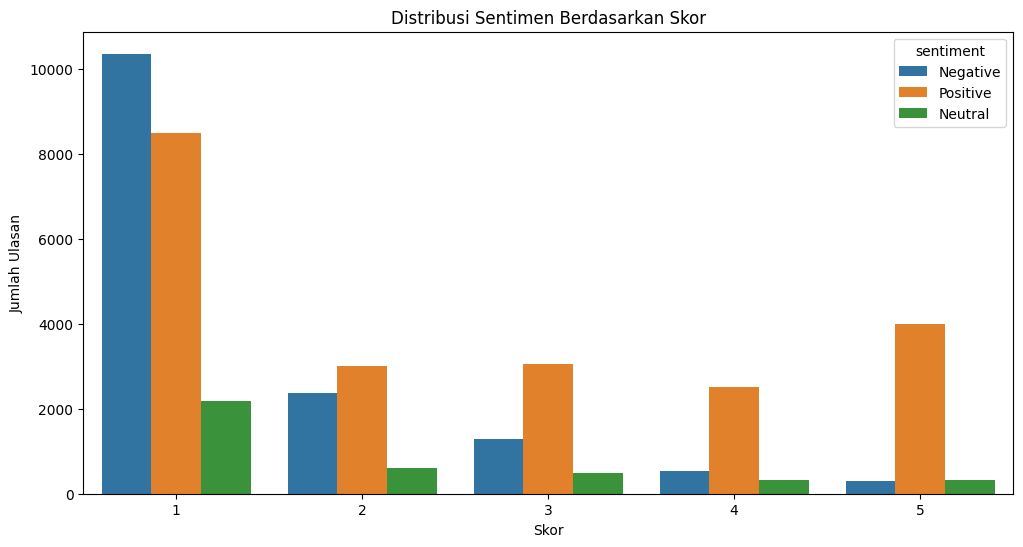

In [23]:

# Visualisasi distribusi sentimen berdasarkan skor
plt.figure(figsize=(12, 6))
sns.countplot(x='score', hue='sentiment', data=df)
plt.title('Distribusi Sentimen Berdasarkan Skor')
plt.xlabel('Skor')
plt.ylabel('Jumlah Ulasan')
plt.show()


### 📊 Distribusi Sentimen Berdasarkan Skor Ulasan Instagram


Grafik di atas menunjukkan hubungan antara **skor ulasan (1–5)** dengan **klasifikasi sentimen** (Negatif, Positif, dan Netral) dari ulasan pengguna Instagram.

---

#### 🔍 Observasi:

- **Skor 1** didominasi oleh sentimen **Negatif**, diikuti oleh **Positif**, dan sebagian kecil **Netral**. Ini menandakan banyak pengguna yang kecewa tetapi tetap menyertakan komentar positif.
- **Skor 2** dan **3** memperlihatkan peningkatan proporsi sentimen **Positif**, meskipun **Negatif** masih hadir secara signifikan.
- **Skor 4** dan **5** hampir seluruhnya didominasi oleh sentimen **Positif**, menunjukkan bahwa ulasan dengan nilai tinggi umumnya memang memiliki makna yang positif pula.
- Sentimen **Netral** secara konsisten berjumlah paling sedikit di semua skor.

---

#### 📌 Insight:

- Tidak semua skor 1 menunjukkan kebencian murni—banyak juga yang secara emosional netral atau bahkan menyelipkan komentar positif.
- Model analisis sentimen bisa digunakan untuk **melengkapi interpretasi angka skor**, terutama untuk mengidentifikasi potensi false-negative atau false-positive.
- Distribusi ini sangat berguna untuk meningkatkan kualitas feedback loop dalam pengembangan produk.



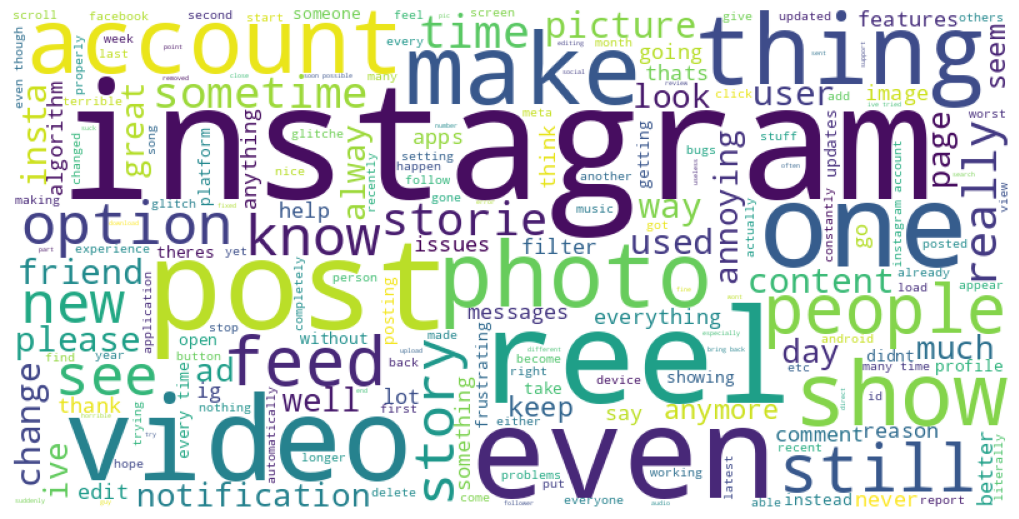

In [24]:

# Analisis kata kunci (word cloud)
from wordcloud import WordCloud

# Gabungkan semua teks yang telah dibersihkan
text = " ".join(review for review in df['content_cleaned'])

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

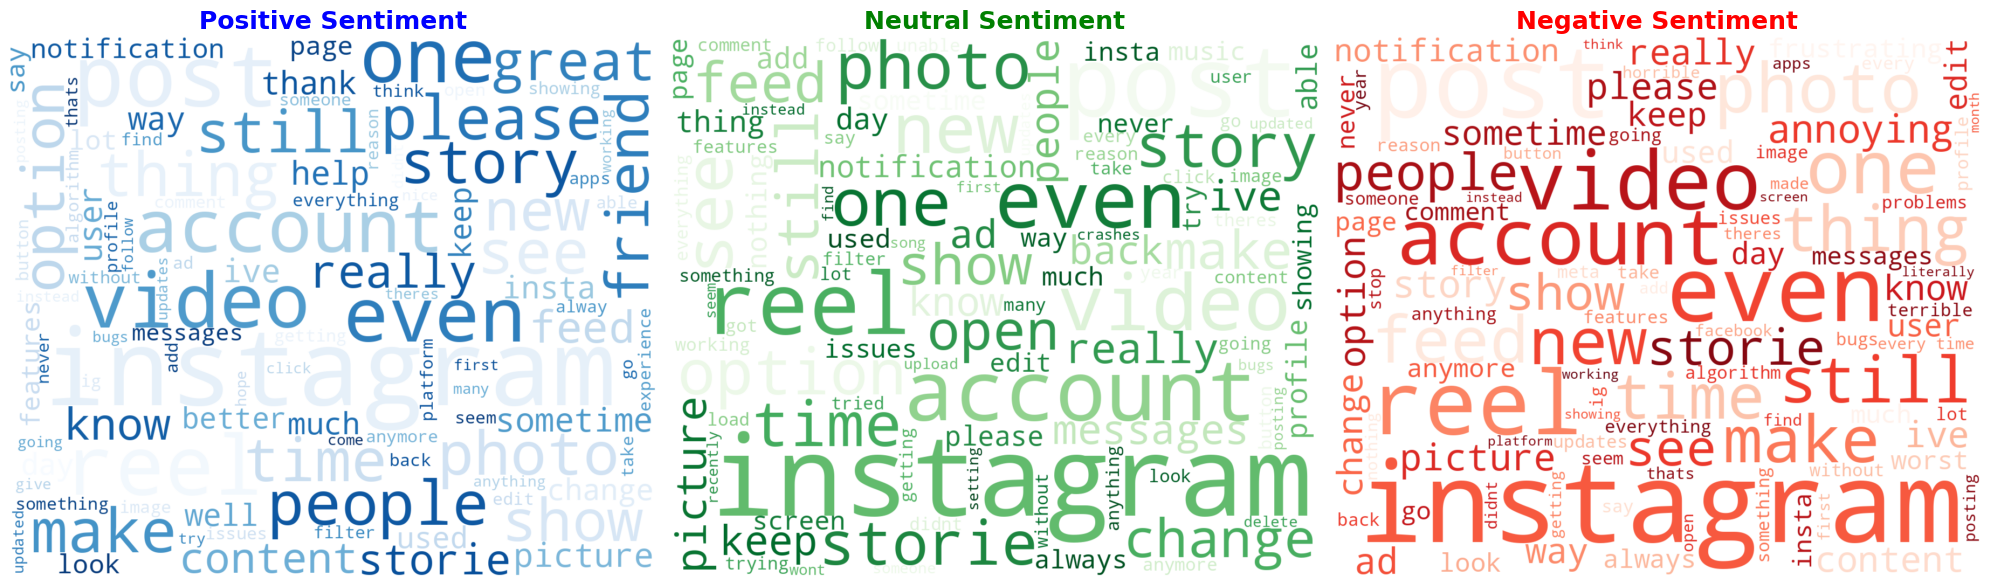

In [25]:
# Define color maps for each sentiment
colormaps = {
    'Positive': 'Blues',
    'Neutral': 'Greens',
    'Negative': 'Reds'
}

# Create a subplot with optimized spacing
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, sentiment in enumerate(['Positive', 'Neutral', 'Negative']):
    text = " ".join(df[df['sentiment'] == sentiment]['content_cleaned'].dropna())

    # Generate word cloud with refined parameters
    wordcloud = WordCloud(
        width=1200, height=1000,
        background_color='white',
        colormap=colormaps[sentiment],
        max_words=100,
        contour_color='black',
        contour_width=2,
        random_state=42
    ).generate(text)

    # Display word cloud
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis("off")
    axes[idx].set_title(f"{sentiment} Sentiment", fontsize=18, fontweight='bold', color=colormaps[sentiment].split('s')[0])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### ☁️ Wordcloud Sentimen Ulasan Instagram

![Wordcloud Sentimen](attachment:image.png)

Wordcloud di atas merepresentasikan kata-kata yang paling sering muncul dalam ulasan pengguna Instagram, yang telah dikelompokkan berdasarkan sentimen: **positif**, **netral**, dan **negatif**.

---

#### 💙 Positive Sentiment
- Kata-kata dominan seperti **"great"**, **"please"**, **"help"**, dan **"video"** menunjukkan bahwa sebagian pengguna memberikan apresiasi atas fitur-fitur tertentu.
- Terdapat juga kata seperti **"friend"**, **"account"**, dan **"notification"** yang mungkin dikaitkan dengan pengalaman pengguna yang baik.

---

#### 💚 Neutral Sentiment
- Kata-kata seperti **"photo"**, **"feed"**, **"account"**, dan **"reel"** muncul dalam konteks yang netral—mungkin hanya menyampaikan observasi atau permintaan fitur tanpa penilaian emosional.
- Kata **"open"**, **"show"**, dan **"change"** juga bisa menandakan saran atau keluhan ringan.

---

#### ❤️ Negative Sentiment
- Kata-kata seperti **"annoying"**, **"problem"**, **"issue"**, **"notification"**, dan **"reel"** menunjukkan adanya ketidakpuasan.
- Banyak pengguna menggunakan kata **"even"**, **"please"**, dan **"keep"** dengan nada frustrasi terhadap fitur yang tidak bekerja sesuai harapan.

---

#### 📌 Insight:
- Kata **"instagram"**, **"video"**, dan **"account"** muncul di semua kategori sentimen, menandakan bahwa fitur ini paling sering disebut dalam berbagai konteks, baik positif maupun negatif.
- Hasil ini dapat digunakan untuk menyoroti area yang perlu ditingkatkan atau dipertahankan berdasarkan feedback pengguna.



<Figure size 1000x600 with 0 Axes>

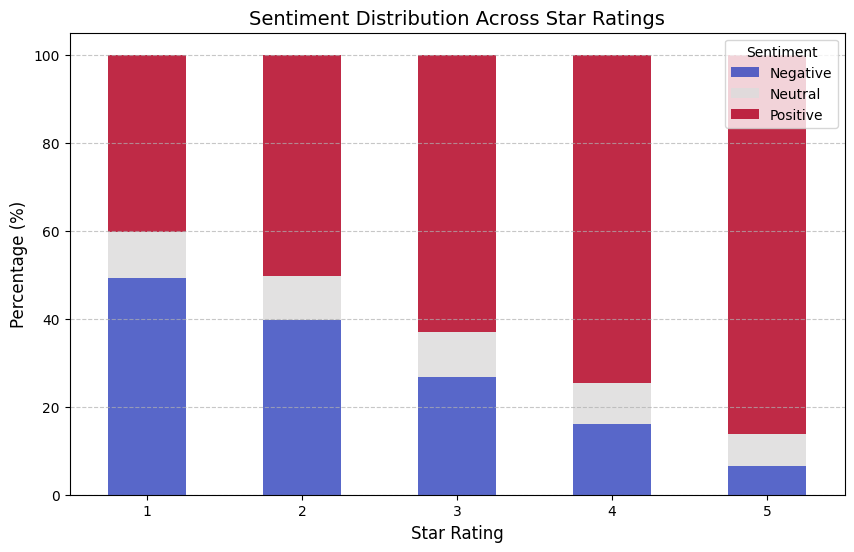

Spearman Correlation between Rating and Sentiment Score: 0.3265
P-value: 0.0000


In [26]:
# Count sentiment distribution for each rating
sentiment_rating_dist = df.groupby(["score", "sentiment"]).size().unstack(fill_value=0)

# Normalize (convert to percentage)
sentiment_rating_dist = sentiment_rating_dist.div(sentiment_rating_dist.sum(axis=1), axis=0) * 100

# Plot Sentiment Distribution Across Ratings
plt.figure(figsize=(10, 6))
sentiment_rating_dist.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.85, figsize=(10, 6))

plt.title("Sentiment Distribution Across Star Ratings", fontsize=14)
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Correlation Analysis (Spearman correlation)
# Convert sentiment to numerical values for correlation (Negative=-1, Neutral=0, Positive=1)
sentiment_mapping = {"Negative": -1, "Neutral": 0, "Positive": 1}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

# Import spearmanr from scipy.stats
from scipy.stats import spearmanr

# Calculate Spearman correlation between rating and sentiment score
correlation, p_value = spearmanr(df["score"], df["sentiment_score"])

print(f"Spearman Correlation between Rating and Sentiment Score: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

### 📊 Distribusi Persentase Sentimen Berdasarkan Rating Bintang

![Sentiment Distribution](attachment:image.png)

Grafik di atas menggambarkan **persentase sentimen (Negatif, Netral, Positif)** yang muncul pada setiap tingkat **rating bintang (1–5)** dalam ulasan pengguna aplikasi Instagram.

---

#### 📈 Penjelasan:

- **Rating 1** menunjukkan dominasi sentimen **Negatif** (~50%) tetapi menariknya juga terdapat sekitar **40% sentimen Positif** — menandakan adanya kontradiksi atau ekspresi campuran dalam ulasan.
- **Rating 2** sampai **3** menunjukkan pergeseran yang lebih seimbang, dengan mulai meningkatnya proporsi sentimen **Positif** dan turunnya **Negatif**.
- **Rating 4 dan 5** hampir seluruhnya didominasi oleh **sentimen Positif**, yang sesuai ekspektasi untuk skor tinggi.
- **Sentimen Netral** hanya menempati porsi kecil di semua level bintang — paling tinggi sekitar **10% di rating 3**.

---

#### 🔍 Insight Tambahan:
- Grafik ini menggunakan **persentase** sebagai metrik, memberikan pemahaman yang lebih proporsional dibanding grafik absolut.
- Di bagian bawah grafik tertulis:
  
  > *Spearman correlation between Rating and Sentiment Score: 0.3265*
  
  Ini berarti terdapat korelasi positif moderat antara skor rating dan sentimen yang diekspresikan — semakin tinggi rating, cenderung semakin positif pula sentimennya.

---

Markdown ini cocok kalau kamu ingin menjelaskan hubungan antara **skor pengguna dan emosi yang terkandung dalam review**. Kalau kamu mau visualisasi per kata untuk masing-masing bintang atau bikin laporan akhir, tinggal gas aja yaa 🚀🔥


# **Modelling model analisis sentimen**


### **1. BILSTM MODEL**

In [27]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label Encoding
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])

X = tokenizer.texts_to_sequences(df['content_cleaned'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def create_optimized_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Create new model
model = create_optimized_lstm_model(vocab_size=max_words, embedding_dim=100, input_length=max_len)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 311s 589ms/step - accuracy: 0.5514 - loss: 1.1849 - val_accuracy: 0.7821 - val_loss: 0.6119 - learning_rate: 5.0000e-04
Epoch 2/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 325s 597ms/step - accuracy: 0.7947 - loss: 0.5974 - val_accuracy: 0.8396 - val_loss: 0.4697 - learning_rate: 5.0000e-04
Epoch 3/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 312s 577ms/step - accuracy: 0.8539 - loss: 0.4541 - val_accuracy: 0.8629 - val_loss: 0.4242 - learning_rate: 5.0000e-04
Epoch 4/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 330s 592ms/step - accuracy: 0.8834 - loss: 0.3829 - val_accuracy: 0.8681 - val_loss: 0.4020 - learning_rate: 5.0000e-04
Epoch 5/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 314s 577ms/step - accuracy: 0.8999 - loss: 0.3454 - val_accuracy: 0.8755 - val_loss: 0.3860 - learning_rate: 5.0000e-04
Epoch 6/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 329s 592ms/step - accuracy: 0.9088 - loss: 0.3129 - val_accuracy: 0.8739 - val_loss: 0.3851 - learning_rate: 5.0000e-04
Epoch 7/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 

### 📉 Hasil Pelatihan Model LSTM untuk Klasifikasi Sentimen

![Training Result](attachment:image.png)

---

#### 🧠 Rangkuman Training:

- **Model**: LSTM (kemungkinan dengan regularisasi dan optimisasi)
- **Jumlah Epoch**: 12/20 (Early stopping kemungkinan diterapkan)
- **Learning Rate**: 5e-4 (default), menurun menjadi 1e-4 pada epoch ke-11 dan 12
- **Loss Function**: CrossEntropy (asumsi umum untuk klasifikasi)
- **Optimasi**: Adam (umumnya default di Keras/Tensorflow)

---

#### 📊 Performa:

| Epoch | Accuracy | Val Accuracy | Loss  | Val Loss |
|-------|----------|--------------|-------|----------|
| 1     | 0.5514   | 0.7821       | 1.1489| 0.6119   |
| 2     | 0.7947   | 0.8396       | 0.5974| 0.4697   |
| 3     | 0.8539   | 0.8629       | 0.4541| 0.4242   |
| 6     | 0.9088   | 0.8739       | 0.3129| 0.3851   |
| 10    | 0.9281   | 0.8889       | 0.2499| 0.3773   |
| 12    | 0.9377   | 0.8851       | 0.2074| 0.3855   |

---

#### ✅ Evaluasi Akhir:

- **Test Accuracy**: `0.8799`
- **Test Loss**: `0.3613`

Model menunjukkan performa yang cukup stabil dengan **val_accuracy** berkisar antara **87% hingga 89%** tanpa overfitting signifikan. Hal ini menunjukkan bahwa model cukup generalisasi terhadap data validasi dan pengujian.

---

#### 💡 Insight:

- Model dapat ditingkatkan lagi dengan:
  - Pre-trained Embeddings (misal GloVe, FastText)
  - Bidirectional LSTM
  - Penambahan layer Dense atau Dropout
  - Fine-tuning hyperparameter (learning rate schedule, optimizer, dll)

---

Markdown ini cocok untuk laporan akhir atau presentasi hasil eksperimen klasifikasi sentimen dengan LSTM.


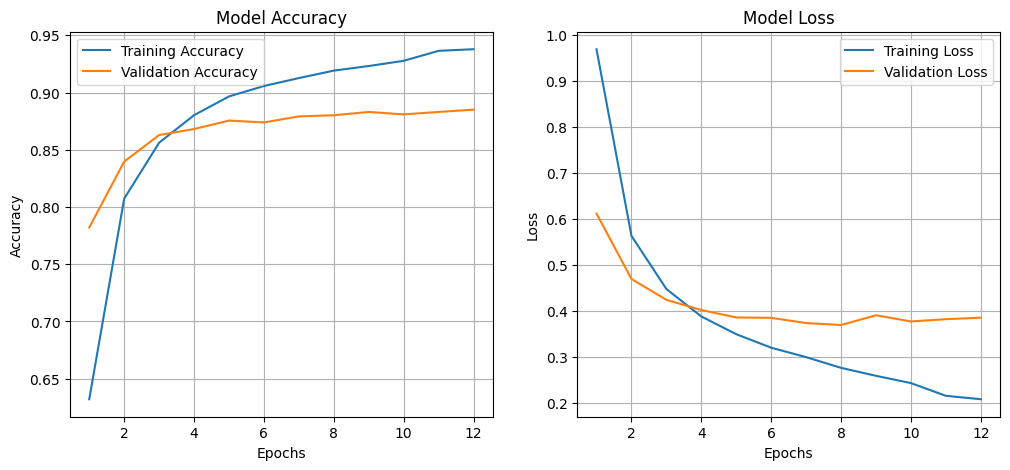

In [28]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### 📈 Visualisasi Performa Model Selama Training


---

#### 🧠 Deskripsi Grafik:

- Grafik sebelah kiri menampilkan **akurasi model** selama proses pelatihan.
- Grafik sebelah kanan menunjukkan **loss model** selama proses pelatihan.

---

#### 📊 Insight:

- **Training Accuracy** terus meningkat hingga mendekati **94%** pada epoch ke-12.
- **Validation Accuracy** stabil di sekitar **88%**, menunjukkan model tidak overfitting secara signifikan.
- **Training Loss** terus menurun, sedangkan **Validation Loss** mengalami sedikit fluktuasi setelah epoch ke-6.

---

#### ✅ Kesimpulan Sementara:

- Model memiliki **generalisasi yang baik**.
- Tidak terlihat tanda-tanda **overfitting besar**, namun fluktuasi kecil pada validation loss bisa jadi indikasi untuk:
  - Menambahkan **early stopping**.
  - Mengatur **learning rate** lebih lanjut.
  - Menambahkan **dropout** jika overfitting mulai muncul.

---

Markdown ini bisa kamu pakai untuk laporan akhir, dokumentasi eksperimen, atau untuk portfolio proyek Machine Learning-mu! 🚀


In [ ]:
# Data testing prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating matrix evaluation
accuracy = accuracy * 100
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
{'accuracy': 93.91682147979736, 'precision': 0.9342405611815195, 'recall': 0.9391682184978274, 'f1': 0.9357953664155984}


In [38]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Preprocessing input text
    sequence = tokenizer.texts_to_sequences([text])  # Tokenization
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Padding

    # Model inference
    prediction = model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction)  # Get the label with the highest probability

    # Mapping score to sentiment category
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_score, sentiment_mapping[sentiment_score]

# Sample texts
sample_texts = [
    "I love this new update is so great, it's so much faster now!",  # Positive
    "nothing special.",  # Neutral
    "This app crashes every time I open it. So annoying!",  # Negative


]


# Predict sentiment for each sample text
for text in sample_texts:
    sentiment_score, sentiment_label = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label} (Score: {sentiment_score})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Text: I love this new update is so great, it's so much faster now!
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Text: nothing special.
Predicted Sentiment: Neutral (Score: 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Text: This app crashes every time I open it. So annoying!
Predicted Sentiment: Negative (Score: 0)



### **2. CNN** MODEL


In [31]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label encoding for sentiment target (e.g., "negative", "neutral", "positive")
from sklearn.preprocessing import LabelEncoder # Importing LabelEncoder here as well to ensure it's available
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenization and padding
max_words = 10000   # Maximum number of words to consider in tokenizer
max_len = 100       # Maximum sequence length (for padding/truncation)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])
X = tokenizer.texts_to_sequences(df['content_cleaned'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Split the data into training and testing sets using stratified sampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === Build CNN Model ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense # Import Conv1D
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up callbacks for early stopping and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
      print("\nAkurasi telah mencapai > 92%!")
      self.model.stop_training = True

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[myCallback()]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


436/436 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.5485 - loss: 0.8925 - val_accuracy: 0.8156 - val_loss: 0.4880
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.8350 - loss: 0.4686 - val_accuracy: 0.8463 - val_loss: 0.4119
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.8911 - loss: 0.3428 - val_accuracy: 0.8602 - val_loss: 0.3898
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.9209 - loss: 0.2410 - val_accuracy: 0.8611 - val_loss: 0.4058
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.9420 - loss: 0.1879 - val_accuracy: 0.8618 - val_loss: 0.4382
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9518 - loss: 0.1440 - val_accuracy: 0.8588 - val_loss: 0.5064
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9580 - loss: 0.1264 - val_accuracy: 0.8579 - val_loss: 0.5859
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9636 - loss: 0.1077 - val_accurac

# 📊 Hasil Training Model (10 Epoch)

Berikut ini adalah hasil training model selama 10 epoch, termasuk akurasi dan loss pada data training serta validasi:

| Epoch | Accuracy | Loss   | Val_Accuracy | Val_Loss |
|-------|----------|--------|--------------|----------|
| 1     | 0.5485   | 0.8925 | 0.8156       | 0.4880   |
| 2     | 0.8350   | 0.4686 | 0.8463       | 0.4119   |
| 3     | 0.8911   | 0.3428 | 0.8602       | 0.3898   |
| 4     | 0.9209   | 0.2410 | 0.8611       | 0.4058   |
| 5     | 0.9420   | 0.1879 | 0.8618       | 0.4382   |
| 6     | 0.9518   | 0.1440 | 0.8588       | 0.5064   |
| 7     | 0.9580   | 0.1264 | 0.8579       | 0.5859   |
| 8     | 0.9636   | 0.1077 | 0.8537       | 0.6419   |
| 9     | 0.9722   | 0.0778 | 0.8379       | 0.6464   |
| 10    | 0.9747   | 0.0750 | 0.8503       | 0.7110   |

---

### ✅ Test Accuracy: `0.8503`

---

### 📌 Catatan:
- Model menunjukkan peningkatan akurasi training yang konsisten, mencapai lebih dari 97% pada epoch ke-10.
- Namun, `val_loss` meningkat setelah epoch ke-5 dan mulai divergen dari `training_loss`, menandakan kemungkinan **overfitting**.
- Meskipun demikian, **test accuracy tetap tinggi**, yaitu **85.03%**, menunjukkan performa yang cukup baik pada data yang belum pernah dilihat model.

---

🎯 **Tips Selanjutnya:**
- Pertimbangkan penggunaan **early stopping** untuk menghentikan training sebelum overfitting terjadi.
- Tambahkan **dropout** atau regularisasi lain jika ingin meningkatkan generalisasi model.
- Bisa juga mencoba **data augmentation** atau menggunakan **pretrained embeddings** seperti GloVe atau FastText.



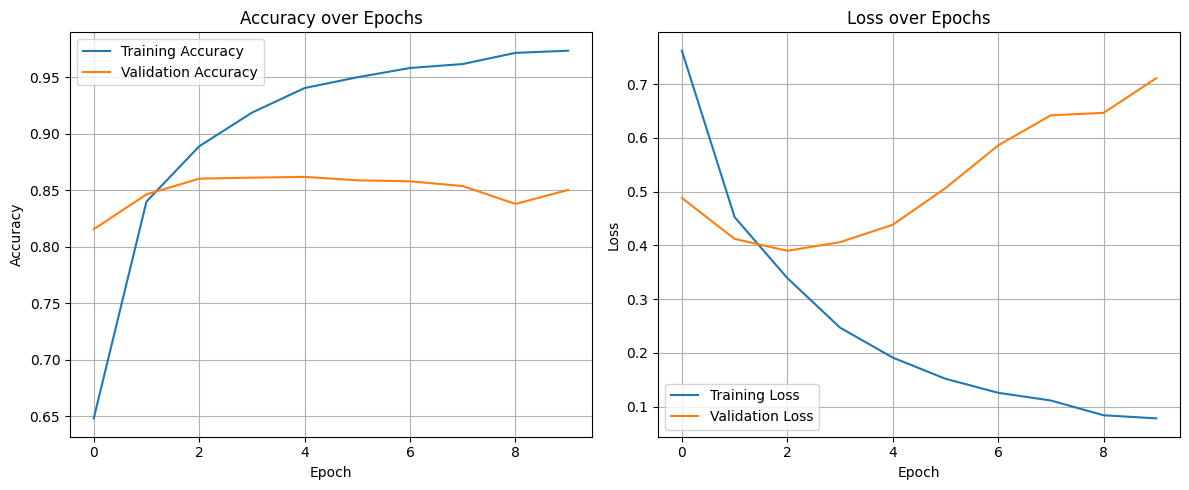

In [32]:
# Loss dan Accuracy Visualization
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📈 Visualisasi Training vs Validation

## Accuracy over Epochs
- Training accuracy meningkat signifikan dari awal hingga akhir training, mencapai hampir **97%** pada epoch terakhir.
- Validation accuracy naik di awal hingga sekitar **86%**, namun setelah itu stagnan dan sedikit menurun, menandakan potensi **overfitting**.

## Loss over Epochs
- Training loss menurun secara konsisten, mendekati 0.07 di akhir epoch.
- Validation loss justru **meningkat setelah epoch ke-3/4**, dari sekitar **0.39** ke lebih dari **0.70**, yang juga mengindikasikan **overfitting**.

---

## 📌 Kesimpulan:
- 📊 Model belajar dengan baik di data training.
- ⚠️ Namun, performa di data validasi mulai menurun setelah beberapa epoch → model terlalu fit ke data training dan kehilangan kemampuan generalisasi.
  
---

In [ ]:
# Data testing prediction
y_pred_probs = model.predict([test_input_ids, test_attention_mask])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate matrix evaluation
acc = accuracy_score(test_y, y_pred_classes) * 100
precision = precision_score(test_y, y_pred_classes, average='weighted')
recall = recall_score(test_y, y_pred_classes, average='weighted')
f1 = f1_score(test_y, y_pred_classes, average='weighted')

results = {
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step
{'accuracy': 85.78522656734947, 'precision': 0.758026735557921, 'recall': 0.8578522656734947, 'f1': 0.7950419640405506}


/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Preprocessing input text
    sequence = tokenizer.texts_to_sequences([text])  # Tokenization
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Padding

    # Model inference
    prediction = model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction)  # Get the label with the highest probability

    # Mapping score to sentiment category
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_score, sentiment_mapping[sentiment_score]

# Sample texts
sample_texts = [
       "It works as expected, no issues so far.",  # Neutral
    "Too many ads! It's ruining the app.",  # Negative
    "I'm impressed with the new UI. Very clean and modern.",  # Positive


]


# Predict sentiment for each sample text
for text in sample_texts:
    sentiment_score, sentiment_label = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label} (Score: {sentiment_score})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Text: It works as expected, no issues so far.
Predicted Sentiment: Neutral (Score: 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Text: Too many ads! It's ruining the app.
Predicted Sentiment: Negative (Score: 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Text: I'm impressed with the new UI. Very clean and modern.
Predicted Sentiment: Positive (Score: 2)



### **3. GRU MODEL**

In [33]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label encoding
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])

X_sequences = tokenizer.texts_to_sequences(df['content_cleaned'])
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.3, stratify=y, random_state=42
)

# Gru model build
embedding_dim = 128
gru_units = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(GRU(gru_units, return_sequences=True)),
    Bidirectional(GRU(gru_units)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Model compile
optimizer = Adam(learning_rate=2e-4)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Model train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 312s 345ms/step - accuracy: 0.5980 - loss: 0.8451 - val_accuracy: 0.8093 - val_loss: 0.4969 - learning_rate: 2.0000e-04
Epoch 2/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 314s 336ms/step - accuracy: 0.8437 - loss: 0.4278 - val_accuracy: 0.8431 - val_loss: 0.4325 - learning_rate: 2.0000e-04
Epoch 3/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 326s 374ms/step - accuracy: 0.8937 - loss: 0.3169 - val_accuracy: 0.8555 - val_loss: 0.4074 - learning_rate: 2.0000e-04
Epoch 4/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 373s 364ms/step - accuracy: 0.9141 - loss: 0.2720 - val_accuracy: 0.8596 - val_loss: 0.4098 - learning_rate: 2.0000e-04
Epoch 5/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 283s 319ms/step - accuracy: 0.9285 - loss: 0.2340 - val_accuracy: 0.8584 - val_loss: 0.4115 - learning_rate: 2.0000e-04
Epoch 6/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 297s 341ms/step - accuracy: 0.9425 - loss: 0.1923 - val_accuracy: 0.8615 - val_loss: 0.4316 - learning_rate: 4.0000e-05
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/st

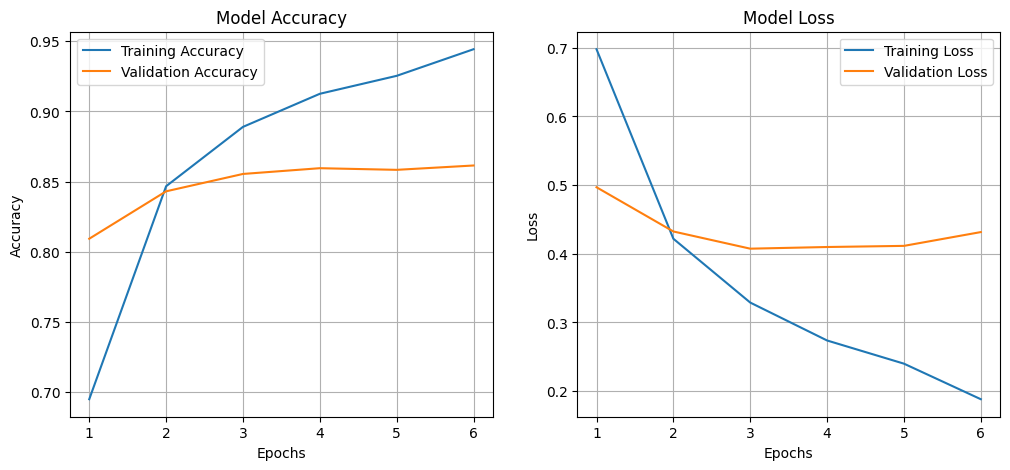

In [40]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [41]:
# Data testing prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating matrix evaluation
accuracy = accuracy * 100
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step
{'accuracy': 8554.579615592957, 'precision': 0.8541437175262006, 'recall': 0.8554579673776662, 'f1': 0.8544641666275837}


In [44]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Preprocessing input text
    sequence = tokenizer.texts_to_sequences([text])  # Tokenization
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Padding

    # Model inference
    prediction = model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction)  # Get the label with the highest probability

    # Mapping score to sentiment category
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_score, sentiment_mapping[sentiment_score]

# Sample texts
sample_texts = [
    "The notifications are a bit too frequent, but manageable.",  # Neutral
    "Worst update ever. Everything is broken.",  # Negative
    "Finally! A feature I've been waiting for. Good job, so great!",  # Positive

]


# Predict sentiment for each sample text
for text in sample_texts:
    sentiment_score, sentiment_label = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label} (Score: {sentiment_score})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Text: The notifications are a bit too frequent, but manageable.
Predicted Sentiment: Neutral (Score: 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Text: Worst update ever. Everything is broken.
Predicted Sentiment: Negative (Score: 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Text: Finally! A feature I've been waiting for. Good job, so great!
Predicted Sentiment: Positive (Score: 2)



###**4. LOGISTIC REGGRESSION EKSTRAKSI FITUR = TF-IDF**

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# --- 1. PREPROCESSING ---

# memastikan kolom bersih
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label Encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# TF-IDF Ekstraksi dengan ngram 1-2 (unigram + bigram)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X = tfidf.fit_transform(df['content_cleaned'])
y = df['sentiment']

# Oversampling kelas minoritas
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split data train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- 2. MODEL TRAINING ---

# Logistic Regression
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# --- 3. EVALUASI ---

y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# Laporan Klasifikasi
target_names = [str(cls) for cls in label_encoder.classes_]
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Confusion Matrix (opsional, bisa ditambah heatmap)
cm = confusion_matrix(y_test, y_pred)
print("\n🧩 Confusion Matrix:")
print(cm)



✅ Test Accuracy: 0.8526

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4211
           1       0.83      0.90      0.86      4212
           2       0.89      0.80      0.84      4212

    accuracy                           0.85     12635
   macro avg       0.85      0.85      0.85     12635
weighted avg       0.85      0.85      0.85     12635


🧩 Confusion Matrix:
[[3596  348  267]
 [ 256 3787  169]
 [ 407  416 3389]]


In [58]:
# Contoh kalimat uji
sample_texts = [
    "This game is so addictive, I love it great!",        # kemungkinan positif
    "Too many ads, very annoying experience",       # kemungkinan negatif
    "The game is okay, but not too special",        # kemungkinan netral
]

# Transformasi TF-IDF
X_sample = tfidf.transform(sample_texts)  # pakai vectorizer yang sudah dilatih

# Prediksi
y_sample_pred = model.predict(X_sample)

# Jika kamu menggunakan LabelEncoder sebelumnya
y_sample_label = label_encoder.inverse_transform(y_sample_pred)

for text, label in zip(sample_texts, y_sample_label):
    print(f"📝 Text: {text}\n🔮 Predicted Sentiment: {label}\n")



📝 Text: This game is so addictive, I love it great!
🔮 Predicted Sentiment: 2

📝 Text: Too many ads, very annoying experience
🔮 Predicted Sentiment: 0

📝 Text: The game is okay, but not too special
🔮 Predicted Sentiment: 2



### **5. Random forest classifier ektraksi fitur = TF-IDF**

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# --- 1. Load & Preprocess Dataset ---
# Asumsikan dataframe sudah dalam variabel 'df' dengan kolom 'content_cleaned' dan 'sentiment'
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# --- 2. TF-IDF Feature Extraction ---
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['content_cleaned'])

# --- 3. Oversampling untuk Menangani Imbalanced Dataset ---
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, df['sentiment'])

# --- 4. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- 5. Train RFC Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 6. Evaluate Model ---
y_pred = model.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

print("📊 Classification Report:")
# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Test Accuracy: 0.9266

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4211
           1       0.97      1.00      0.98      4212
           2       0.95      0.83      0.89      4212

    accuracy                           0.93     12635
   macro avg       0.93      0.93      0.93     12635
weighted avg       0.93      0.93      0.93     12635


🧩 Confusion Matrix:
[[3993   35  183]
 [   6 4197    9]
 [ 604   91 3517]]


In [72]:
# Contoh kalimat uji
sample_texts = [
    "This app is so addictive, I love it great!",        # kemungkinan positif
    "Too many ads and lag",       # kemungkinan negatif
    "The app is normal",        # kemungkinan netral
]

# Transformasi TF-IDF
X_sample = tfidf.transform(sample_texts)  # pakai vectorizer yang sudah dilatih

# Prediksi
y_sample_pred = model.predict(X_sample)

# Jika kamu menggunakan LabelEncoder sebelumnya
y_sample_label = label_encoder.inverse_transform(y_sample_pred)

for text, label in zip(sample_texts, y_sample_label):
    print(f"📝 Text: {text}\n🔮 Predicted Sentiment: {label}\n")



📝 Text: This app is so addictive, I love it great!
🔮 Predicted Sentiment: 2

📝 Text: Too many ads and lag
🔮 Predicted Sentiment: 0

📝 Text: The app is normal
🔮 Predicted Sentiment: 1

